In [2]:
import pandas as pd
import numpy as np

# Step 1: Load data
df = pd.read_csv(
    "household_power_consumption.txt",
    sep=';',
    na_values='?',
    parse_dates={'datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    low_memory=False
)

# Step 2: Clean and filter
df = df.dropna()
df = df.astype({
    'Global_active_power': float,
    'Global_reactive_power': float,
    'Voltage': float,
    'Global_intensity': float,
    'Sub_metering_1': float,
    'Sub_metering_2': float,
    'Sub_metering_3': float
})

# Step 3: Feature Engineering
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.weekday
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['total_sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']

# Step 4: Time filter (first 2 weeks of 2007)
df = df[(df['datetime'] >= '2007-01-01') & (df['datetime'] < '2007-01-15')]

print(df.head())


/tmp/ipython-input-2-3294153855.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/tmp/ipython-input-2-3294153855.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/tmp/ipython-input-2-3294153855.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


                 datetime  Global_active_power  Global_reactive_power  \
21996 2007-01-01 00:00:00                2.580                  0.136   
21997 2007-01-01 00:01:00                2.552                  0.100   
21998 2007-01-01 00:02:00                2.550                  0.100   
21999 2007-01-01 00:03:00                2.550                  0.100   
22000 2007-01-01 00:04:00                2.554                  0.100   

       Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
21996   241.97              10.6             0.0             0.0   
21997   241.75              10.4             0.0             0.0   
21998   241.64              10.4             0.0             0.0   
21999   241.71              10.4             0.0             0.0   
22000   241.98              10.4             0.0             0.0   

       Sub_metering_3  hour  day_of_week  is_weekend  total_sub_metering  
21996             0.0     0            0           0                 0.0  
21

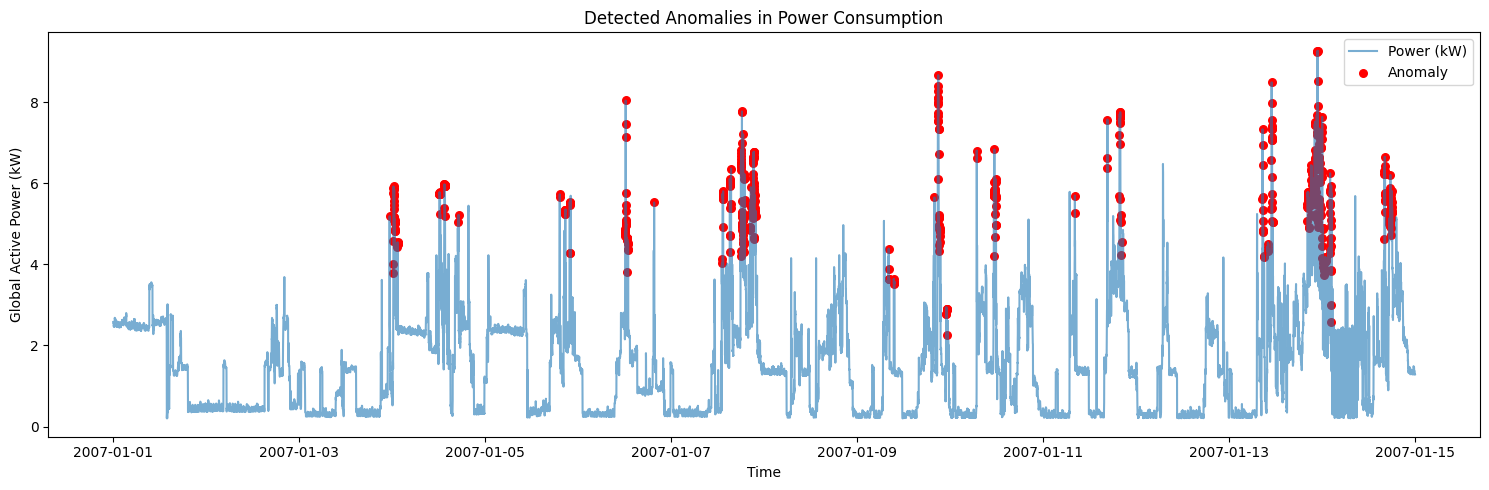

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib # Import joblib

# Step 1: Select features for anomaly detection
features = [
    'Global_active_power', 'Voltage', 'hour', 'day_of_week', 'total_sub_metering'
]
X = df[features]

# Step 2: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
iso_forest.fit(X_scaled)  # Fit the model here

# Save the trained model and scaler
joblib.dump(iso_forest, "iso_model.pkl")
joblib.dump(scaler, "scaler.pkl")

df['anomaly_score'] = iso_forest.decision_function(X_scaled)
df['anomaly'] = iso_forest.predict(X_scaled)  # -1 = anomaly, 1 = normal

# Step 4: Convert anomaly label for easier plotting
df['is_anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Step 5: Plot results
plt.figure(figsize=(15, 5))
plt.plot(df['datetime'], df['Global_active_power'], label='Power (kW)', alpha=0.6)
plt.scatter(df[df['is_anomaly'] == 1]['datetime'], df[df['is_anomaly'] == 1]['Global_active_power'],
            color='red', label='Anomaly', s=30)
plt.title('Detected Anomalies in Power Consumption')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

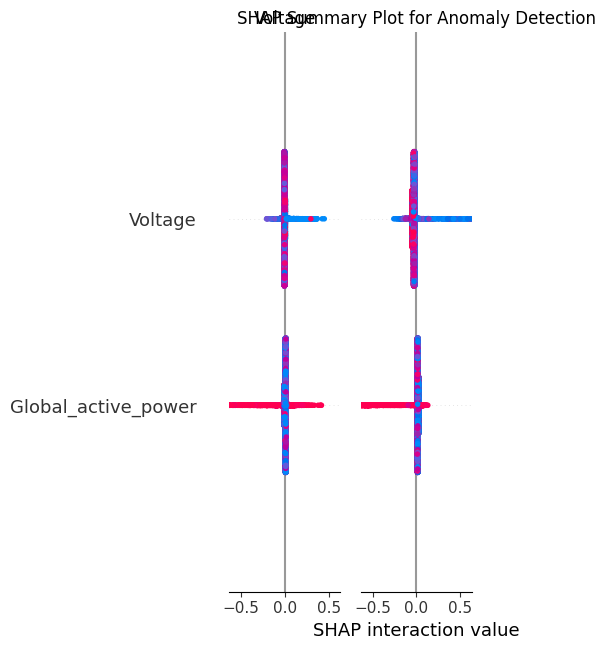

<Figure size 640x480 with 0 Axes>

In [10]:
# 📦 Required: pip install shap matplotlib scikit-learn
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Step 1: Select the same features used in Isolation Forest
features = [
    'Global_active_power', 'Voltage', 'hour', 'day_of_week', 'total_sub_metering'
]
X = df[features]
y = df['is_anomaly']  # 1 = anomaly, 0 = normal (from Isolation Forest)

# Step 2: Train a surrogate model (RandomForest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Step 3: Use SHAP to explain the model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X)

# Step 4: Global explanation
plt.figure(figsize=(10, 6)) # Increase figure size
shap.summary_plot(shap_values, X, show=False) # Use show=False to prevent immediate display
plt.title('SHAP Summary Plot for Anomaly Detection') # Add a title
plt.tight_layout()
plt.show() # Explicitly show the plot

# Optional: Save plot
plt.savefig("shap_summary.png")

### Save Streamlit App Code to a File

### Run the Streamlit App